# Yelp Database Spacial Analysis

This notebook is a complement to the Yelp Data Analysis project, where some aspects of the most sucessful business on Yelp are analised, specially the spatial data.

Questions analised:

- Does any region have business with higher ratings?
- Does any region have business with more checkins?
- Which categories have higher ratings?
- Which attributes contribute more to a higher rating?

## Imports and Setup

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keplergl import KeplerGl
from pyspark.sql import SparkSession, functions as f
from dotenv import load_dotenv
from MapConfigs.map_configs import count_map, stars_map, checkins_map

In [2]:
load_dotenv()
awsAccessKey = os.environ.get('AWS_ACCESS_KEY')
awsAccessSecret = os.environ.get('AWS_ACCESS_SECRET')
awsS3Directory = os.environ.get('AWS_S3_DIRECTORY')

## Read Data

For the analysis on this notebook, three main datasets stored on the Data Lake are needed:

- The business_data dataset from the Silver Layer, which basically cleaned and formatted data about the business;
- The reviews_view dataset from the Gold Layer, which contains the review data grouped by Business (Here, only the Average of Stars is needed)
- The checkins_view dataset from the Gold Layer, which contains data about the Checkins agreggated by Business (Here, only the Total of Checkins by Business is needed).

This three datasets where directly obtained by the Data Lake on AWS S3 using Pyspark as a tool to load and filter them according to the needs. After loading, all three dataframes were converted to Pandas and joined together to form a unique dataframe.

In [3]:
spark = SparkSession.builder.appName("Business Data Analysis").getOrCreate()

spark.sparkContext\
     ._jsc.hadoopConfiguration().set("fs.s3a.access.key", awsAccessKey)
spark.sparkContext\
     ._jsc.hadoopConfiguration().set("fs.s3a.secret.key", awsAccessSecret)
spark.sparkContext\
      ._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.amazonaws.com")
spark.sparkContext\
      ._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")

business_df = spark.read.option("inferSchema","true").parquet(awsS3Directory + "/Silver/business_data").toPandas()
business_ratings_df = spark.read.option("inferSchema","true").parquet(awsS3Directory + "/Gold/reviews_view")\
                           .select(["business_id","avg_stars"]).toPandas()
business_checkins_df = spark.read.option("inferSchema","true").parquet(awsS3Directory + "/Gold/checkins_view")\
                           .groupBy("business_id").agg(f.sum("count").alias("checkins")).toPandas()

23/03/28 20:27:33 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.0.16 instead (on interface enp0s31f6)
23/03/28 20:27:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/28 20:27:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/28 20:27:35 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [4]:
full_df = business_df.merge(business_ratings_df,how="left",on="business_id")
full_df = full_df.merge(business_checkins_df,how="left",on="business_id")
full_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours,attributes_list,avg_stars,checkins
0,xKoz9eM8hUELf5qixexeJQ,African Plum Home & More,120 W Main St,Plainfield,IN,46168,39.703083,-86.402771,NaN,5,1,"Home & Garden, Home Decor, Furniture Stores, S...","(12:0-17:0, None, 9:0-15:0, 9:0-15:0, None, 10...",,4.500000,5.0
1,yiE_Iym7A9wa6tyJHkWzhw,Craft Fry Wing,2224 E Fletcher Ave,Tampa,FL,33612,28.069622,-82.433075,NaN,43,1,"Cheesesteaks, Bubble Tea, Food, Burgers, Chick...","(12:0-22:0, None, 11:0-22:0, 11:0-22:0, 11:0-2...","BikeParking,BusinessAcceptsCreditCards,Caters,...",4.295455,63.0
2,7d9X9wnm_35UcdJRJNu_Sw,China King,7811 US 31 S,Indianapolis,IN,46227,39.652946,-86.136276,NaN,22,1,"Restaurants, Chinese","(11:30-22:0, 10:30-22:0, None, 10:30-22:0, 10:...","BikeParking,BusinessAcceptsCreditCards,GoodFor...",3.772727,49.0
3,CFPWVAFSP3Ktfe-cEXeKoA,Liberty Real Estate Associates,924 Arch St,Philadelphia,PA,19107,39.953133,-75.155746,NaN,15,1,"Home Services, Real Estate Services, Real Estate",None,,1.666667,NaN
4,EgZH_qXEQH_WJyNFgRaWDw,Jamie,4317 Harding Pike,Nashville,TN,37205,36.126026,-86.845444,NaN,6,0,"Shopping, Accessories, Women's Clothing, Fashion","(None, 10:0-17:30, 10:0-19:0, 10:0-17:30, 10:0...",BusinessAcceptsCreditCards,3.000000,69.0


## Attributes Analysis

Let's start with the last question first, and analyze if there's any business_attribute that contributes more to a higher rating. 

In [5]:
df_attributes = full_df.loc[:,["business_id","attributes_list","avg_stars","checkins"]]
df_attributes = df_attributes[df_attributes["attributes_list"] != ""]

After obtaining the needed columns, a pre-processing of the attributes column is needed, since it's on a string format containing all the business attributes separated by comma. To normalize this, we need first to split this string format into a list of attributes and then apply the explode operation, which creates a new dataset row for each of the list elements, resulting in a dataframe containing one attribute for a business at each row.

In [6]:
df_attributes["attribute"] = df_attributes["attributes_list"].apply(lambda x: str.split(x,","))
df_attributes = df_attributes.explode("attribute").drop("attributes_list",axis=1)

Then, to reach the data needed to plot, the last step is to group by the data by the attribute averaging the ratings of the business.

In [7]:
plot_data = df_attributes.drop("checkins",axis=1).groupby("attribute").mean("avg_stars")
plot_data = plot_data.reset_index()
plot_data.columns =  ['Attributes','Average Ratings']
plot_data = plot_data.sort_values('Average Ratings')

Text(0, 0.5, 'Attributes')

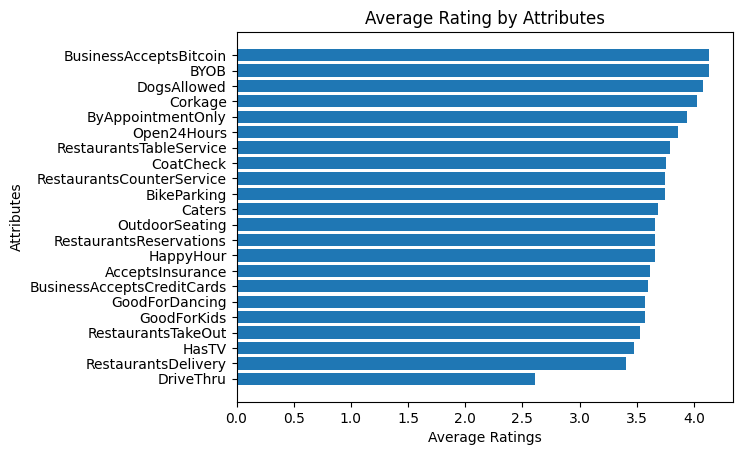

In [8]:
plt.barh(plot_data["Attributes"],plot_data["Average Ratings"])
plt.title("Average Rating by Attributes")
plt.xlabel("Average Ratings")
plt.ylabel("Attributes",)

Despite some attributes have a higher average rating than others, it seems that there isn't an specific attribute that leads to a considerable increase on ratings, compared to others. However, there's still some interesting insights that could be taken:

- The Acceptance of Bitcoins has a Average Rating higher than the Acceptance of Credit Cards, which is quite relevant, considering the rise of cripto coins.
- In the case of Restaurant Attributes, it's interesting to see that local attributes such as BYOB (Bring your own bottle), Table Service and By Appointment Only are higher ratings that Delivery, Drive Thru and Take Out. It's not like local services are more important, but they seem to have more room to impress and create a good customer experience worthy of a good review. In a certain way, that could also be seen as an opportunity to stand out from competitors by creating a better delivery, drive thru and takeout experiences.
- The permission of dogs appears to be an really important topic for customers, even more important than service facilities.

Let's check now if there's any relation between Attributes and number of checkins.

In [9]:
plot_data = df_attributes.drop("avg_stars",axis=1).groupby("attribute").mean("checkins")
plot_data = plot_data.reset_index()
plot_data.columns =  ['Attributes','Average Checkins']
plot_data = plot_data.sort_values('Average Checkins')

Text(0, 0.5, 'Attributes')

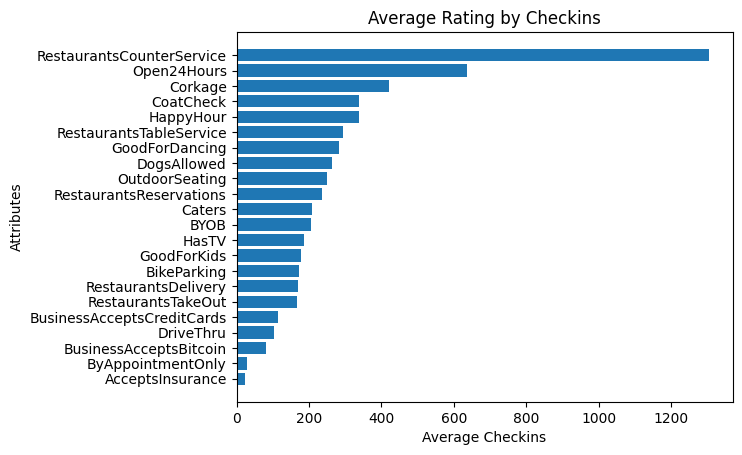

In [10]:
plt.barh(plot_data["Attributes"],plot_data["Average Checkins"])
plt.title("Average Rating by Checkins")
plt.xlabel("Average Checkins")
plt.ylabel("Attributes")

Now, in terms of checkins, a considerable difference can be found. The Restaurants with Counter Service presents, on average, a considerable higher number of Checkins. 

> The Counter Service is the type of model for restaurants, where customers make their orders on a Point of Sale, generally a bar or a counter, instead of sitting on a table and make orders to a waiter, which consists of the Table Service model.  

As this kind of service is quite common for fast food restaurants, is quite expected for this attribute to leads to more checkins. 

## Categories Analysis

To analize the Categories, let's start applying a process similar to what was done with the attributes, in a way to obtain a normalized dataset with only one category per row.

In [11]:
df_categories = full_df.loc[:,["business_id","categories","avg_stars","checkins"]]
df_categories = df_categories[~df_categories["categories"].isnull()]

In [12]:
df_categories["categories"] = df_categories["categories"].apply(lambda x: x.replace(", ", ",")) #Normalize Separators
df_categories["category"] = df_categories["categories"].apply(lambda x: str.split(x,","))
df_categories = df_categories.explode("category").drop("categories",axis=1)

In [13]:
df_categories

,business_id,avg_stars,checkins,category
0,xKoz9eM8hUELf5qixexeJQ,4.500000,5.0,Home & Garden
0,xKoz9eM8hUELf5qixexeJQ,4.500000,5.0,Home Decor
0,xKoz9eM8hUELf5qixexeJQ,4.500000,5.0,Furniture Stores
0,xKoz9eM8hUELf5qixexeJQ,4.500000,5.0,Shopping
1,yiE_Iym7A9wa6tyJHkWzhw,4.295455,63.0,Cheesesteaks
...,...,...,...,...
150344,mtGm22y5c2UHNXDFAjaPNw,3.916667,25.0,Bikes
150345,jV_XOycEzSlTx-65W906pg,4.333333,2.0,Beauty & Spas
150345,jV_XOycEzSlTx-65W906pg,4.333333,2.0,Permanent Makeup
150345,jV_XOycEzSlTx-65W906pg,4.333333,2.0,Piercing


The Categories field is composed of more than a thousand different categories, which makes quite difficult to visually analize it as a whole. But since each business can have multiple categories, it's quite possible that a few generic categories could cover most of them. To try this idea, I manually selected some categories that cover at least a 1000 business. Let's filter the data and check how much business still remains on the data. 

In [14]:
business_before_filter = df_categories["business_id"].nunique()

In [15]:
selected_categories = ['Food','Shopping','Home Services','Beauty & Spas','Nightlife',
                       'Health & Medical','Automotive','Event Planning & Services',
                       'Hotels & Travel','Home & Garden','Fashion','Arts & Entertainment',
                       'Pets','Fitness & Instruction','Education','Financial Services','Electronics']

df_categories = df_categories[df_categories["category"].isin(selected_categories)]

In [16]:
business_after_filter = df_categories["business_id"].nunique()

print("The filtered business compose " + str(np.round(business_after_filter*100/business_before_filter,2)) + "% of the total number of business.")

The filtered business compose 76.7% of the total number of business.


With a reasonable sample size of business, let's now proceed to plot the data.

In [17]:
plot_data = df_categories.drop("checkins",axis=1).groupby("category").mean("avg_stars")
plot_data = plot_data.reset_index()
plot_data.columns =  ['Categories','Average Ratings']
plot_data = plot_data.sort_values('Average Ratings')

Text(0, 0.5, 'Categories')

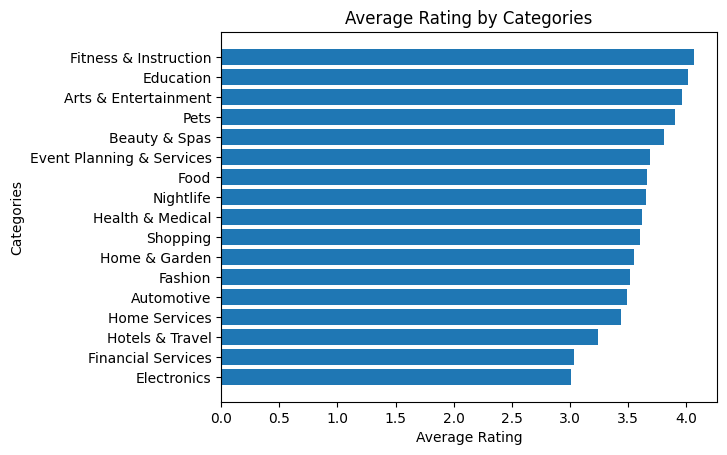

In [18]:
plt.barh(plot_data["Categories"],plot_data["Average Ratings"])
plt.title("Average Rating by Categories")
plt.xlabel("Average Rating")
plt.ylabel("Categories")

Again, in terms of Ratings, there's no siginificant diferrence in average ratings, but a few insight's can be taken:

- First, it seems that categories related to service provision domains the higher ratings more than product selling categories.
- It's interesting to see on the top ratings categories somewhat related to self-care, such as Fitness, Beauty & Spas (and somewhat Education). Since, the results of these services are applied on the consumer itself, it feels like they can lead to more positive experiences, compared to a product selling, for example.
- Here, similar to the attributes analysis, the Pet Category appear with high ratings. 

Let's produce now the same analysis, but in terms of checkins.

In [19]:
plot_data = df_categories.drop("avg_stars",axis=1).groupby("category").mean("checkins")
plot_data = plot_data.reset_index()
plot_data.columns =  ['Categories','Average Checkins']
plot_data = plot_data.sort_values('Average Checkins')

Text(0, 0.5, 'Categories')

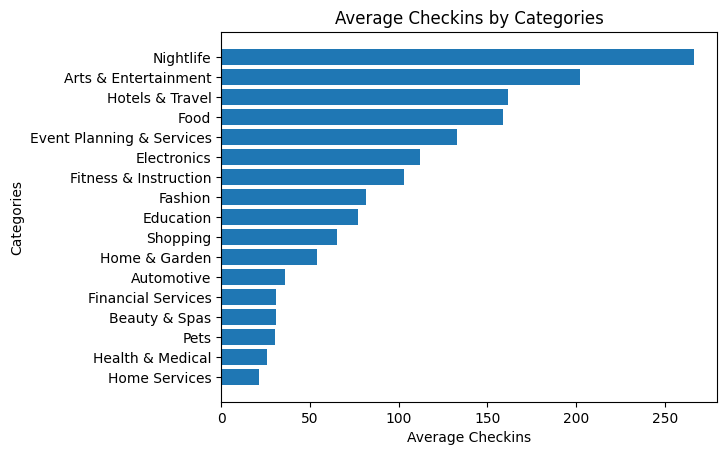

In [20]:
plt.barh(plot_data["Categories"],plot_data["Average Checkins"])
plt.title("Average Checkins by Categories")
plt.xlabel("Average Checkins")
plt.ylabel("Categories")

As for checkins, we see again some considerable differences. The pattern of results here, however, seem quite related to the user behaviours of Yelp. It's important to remember that checkins are not something mandatory for each user, making it's data suitable to bias according to users behaviour and specially business categories where checkins tend to be more used. 

> Which place is more likely to a Yelp user make a checkin to share his current location with friends: A night club or a car workshop? 
 
This kind of behaviour is what appears to rule the results on the plot above. Business somewhat related to leisure, such as Nightlife, Hotels and Food, seem more prone to get more checkins.

## Spatial Analysis

Finally, let's head back to the first questions made involving spaciality. I purposely inverted the order, because the definition of categories done on the last step would really help here, since just plotting all business on a map doesn't bring much information, but at the same time, there were too much categories, as we saw before. For this analysis, we will further the number of categories, to facilitate the analysis, and only the above will be considered:

- Food
- Shopping
- Beauty & Spas
- Fitness & Instruction
- Nightlife
- Health & Medical
- Automotive
- Education

This selection was only based on the potential of these analysis giving any information about the users behaviours of a certain region. For example, analyzing Hotel & Travel categories would probably only highlight more touristic locations between the cities contained on the dataset. 

The maps where plotted using KeplerGL, a really cool map library. Inside it, the hex plot was used, where bar plots are created over a hexagonal area, and it's height represented a configured data metric (in this case, the total number of business, average of stars and average of checkins). For the following plots, the area covered by each hexagon covers a radius of 70km, selected arbitrarily. 

In [21]:
df_space = full_df.loc[:,["business_id","categories","latitude","longitude","avg_stars","checkins"]]
df_space = df_space[~df_space["categories"].isnull()]

In [22]:
df_space["categories"] = df_space["categories"].apply(lambda x: x.replace(", ", ",")) #Normalize Separators
df_space["category"] = df_space["categories"].apply(lambda x: str.split(x,","))
df_space = df_space.explode("category").drop("categories",axis=1)

In [23]:
selected_categories = ["Food","Shopping","Beauty & Spas","Fitness & Instruction","Nightlife","Health & Medical","Automotive","Education"]

df_space = df_space[df_space["category"].isin(selected_categories)]

In [24]:
df_space

,business_id,latitude,longitude,avg_stars,checkins,category
0,xKoz9eM8hUELf5qixexeJQ,39.703083,-86.402771,4.500000,5.0,Shopping
1,yiE_Iym7A9wa6tyJHkWzhw,28.069622,-82.433075,4.295455,63.0,Food
4,EgZH_qXEQH_WJyNFgRaWDw,36.126026,-86.845444,3.000000,69.0,Shopping
5,b3KxHgc7le1Mc2Q3OFsszw,53.547955,-113.535240,3.500000,2.0,Shopping
6,2tAi411srrpmMofeAKdACw,32.362690,-111.120750,3.401709,47.0,Food
...,...,...,...,...,...,...
150342,c8GjPIOTGVmIemT7j5_SyQ,36.115116,-86.766922,4.333333,33.0,Shopping
150343,_QAMST-NrQobXduilWEqSw,39.908707,-86.065086,3.500000,5.0,Shopping
150343,_QAMST-NrQobXduilWEqSw,39.908707,-86.065086,3.500000,5.0,Beauty & Spas
150344,mtGm22y5c2UHNXDFAjaPNw,38.782352,-89.950562,3.916667,25.0,Shopping


### Food Business

Let's start analyzing Food's Business. For this and further sections, three graphs will be presented, in this order:

- Total of Business by Location
- Average of Stars by Location
- Average Checkins by Location

#### Total Business

In [25]:
df_food = df_space[df_space["category"] == "Food"]

In [26]:
map = KeplerGl(height=500, data={'data': df_food},config=count_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For total number of business, it seems like the East Coast of US have significantly more business.

#### Stars

In [27]:
map = KeplerGl(height=500, data={'data': df_food},config=stars_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For Stars, the West coast business presents higher averages.

#### Checkins

In [28]:
map = KeplerGl(height=500, data={'data': df_food},config=checkins_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

Checkins are somewhat more distributed, but with Los Angeles and San Francisco with the highest througout the data.

### Shopping

In [29]:
df_shopping = df_space[df_space["category"] == "Shopping"]

#### Total Business

In [30]:
map = KeplerGl(height=500, data={'data': df_shopping},config=count_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For shopping business, the East coast seems to have more business, specially with NYC and Tampa.

#### Stars

In [31]:
map = KeplerGl(height=500, data={'data': df_shopping},config=stars_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For stars, we see a more distributed result, with slightly higher averages on West Coast.

#### Checkins

In [32]:
map = KeplerGl(height=500, data={'data': df_shopping},config=checkins_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For checkins, the East Coast have a considerable edge.

### Beauty & Spas

In [33]:
df_beauty = df_space[df_space["category"] == "Beauty & Spas"]

#### Total of Business

In [34]:
map = KeplerGl(height=500, data={'data': df_beauty},config=count_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For Beauty and Spas, we see a predominance of business on the East Coast.

#### Stars

In [35]:
map = KeplerGl(height=500, data={'data': df_beauty},config=stars_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For Stars, there's a considerable advantage on the West Coast.

#### Checkins

In [36]:
map = KeplerGl(height=500, data={'data': df_beauty},config=checkins_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

Here, for checkins, we see a slight edge for the West Coast.

### Fitness & Instruction

In [37]:
df_fit = df_space[df_space["category"] == "Fitness & Instruction"]

#### Total of Business

In [38]:
map = KeplerGl(height=500, data={'data': df_fit},config=count_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For Fitness Business, we see a pattern of more business on the East coast.

#### Stars

In [39]:
map = KeplerGl(height=500, data={'data': df_fit},config=stars_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For stars, we have a more distributed pattern, with high averages both on East and West.

#### Checkins

In [40]:
map = KeplerGl(height=500, data={'data': df_fit},config=checkins_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For checkins, however, there's a large advantage on the East Coast.

### Nightlife

In [41]:
df_night = df_space[df_space["category"] == "Nightlife"]

#### Total of Business

In [42]:
map = KeplerGl(height=500, data={'data': df_night},config=count_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For Nightlife Business, the East Coast presents more business in number.

#### Stars

In [43]:
map = KeplerGl(height=500, data={'data': df_night},config=stars_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For Stars, we see a predominance on the West Coast of higher ratings.

#### Checkins

In [44]:
map = KeplerGl(height=500, data={'data': df_night},config=checkins_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For Checkins, there's a more distributed pattern.

### Health & Medical

In [45]:
df_health = df_space[df_space["category"] == "Health & Medical"]

#### Total of Business

In [46]:
map = KeplerGl(height=500, data={'data': df_health},config=count_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

We see here a higher concentration of Health business on the East Coast. With this category, however, the difference is quite high compared to other categories.

#### Stars

In [47]:
map = KeplerGl(height=500, data={'data': df_health},config=stars_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For Stars, the West coast again presents higher values, but not so much compared to the East Coast.

#### Checkins

In [48]:
map = KeplerGl(height=500, data={'data': df_health},config=checkins_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

The Checkins, however, are considerable higher on the East Coast. Considering that for the other categories, the Checkins are generally higher on the West Coast, this pattern can be a strong indicative of a higher usage of this kind of service on this area.

### Automotive

In [49]:
df_auto = df_space[df_space["category"] == "Automotive"]

#### Total of Business

In [50]:
map = KeplerGl(height=500, data={'data': df_auto},config=count_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

The predominance of Business on the East pattern is seen again here for Automotive Business.

#### Stars

In [51]:
map = KeplerGl(height=500, data={'data': df_auto},config=stars_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For stars, we see an overall predominance on the West Coast, with Boston as an outlier on the East Coast.

#### Checkins

In [52]:
map = KeplerGl(height=500, data={'data': df_auto},config=checkins_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For checkins, the predominance is on the East Side, as opposed to the general behaviour as seen on other categories.

### Education

In [53]:
df_edu = df_space[df_space["category"] == "Education"]

#### Total of Business

In [54]:
map = KeplerGl(height=500, data={'data': df_edu},config=count_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For Education, the number of business is predominant on the East Coast, with high concentrations on New York and Tampa.

#### Stars

In [55]:
map = KeplerGl(height=500, data={'data': df_edu},config=stars_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

For stars, there's a distributed pattern overall, without any city being considerable over any other.

#### Checkins

In [56]:
map = KeplerGl(height=500, data={'data': df_edu},config=checkins_map)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/andre/.pyenv/versions/3.8.10/envs/yelp-env/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '322xd98', 'type': …

Checkins are higher on the East Coast, with high peaks on New York and Florida.

### Map Analysis Insights

After all these map analysis, some patterns can be clearly identified and some insight can be taken:

- First, most of the maps presents a different behaviour for the East and West coast of the United States.
- In general, the East Coast presents significantly more business registered on Yelp, while the West Coast presents slight advantages in Average of Stars and Checkins.
- The cities with apparently higher usages of Yelp are Tampa, New York City, New Orleans, Los Angeles and San Franscisco.
- Some interesting outliers to this general pattern:
  - Checkins are considerable higher on East Coast for Shoppings, Fitness, Health & Medical, Automotive and Education.
  - Food, Beauty & Spas, Nightlife and Health & Medical have an higher average of stars on the West Coast compared to the East Coast.

## Conclusion

Despite the simple analysis done on this notebook, some interesting insights could be taken from the data, some of them confirming some ideas, others bringing to light some new patters. Just to recap, throughout this notebook we learned:
- Fast Food and Counter Service Restaurants naturally leads to more visits (and thus to more Yelp Checkins), but Table Service Restaurants, with more "in loco" attributes, such as Bring Your Own Bottle leads to better customer experiences (and greater Reviews).
- Services which results affects the user itself, such as Fitness & Instruction, Education and Beauty & Spas, generally have higher ratings, which seems related to more remarkable experiences.
- Some services, such as Food and Nightlife, have a greater tendency to have more checkins by their users.
- The East Coast have a greater number of Business, while the West Coast, have higher business ratings.

## Further Steps

Possible future steps to increase this work could be:

- Analize the Spatial Distribution of Users;
- Find Checkin Frequency Patterns for each Category;
- Recommend Business to Users based on their Reviews or recommend Potential Customers to Business;